In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:

bag = rosbag.Bag('/home/uware/rosbags/static/translation/36h11_s_z_2-4-6-8-10_1080_20.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,2.432631
1,0.631532,2.309044
2,1.367185,2.259755
3,2.110958,2.173829
4,2.931993,2.078507
...,...,...
298,97.088011,7.959539
299,97.357397,7.983308
300,97.663938,7.983211
301,98.021016,8.027403


<AxesSubplot:xlabel='relative_time'>

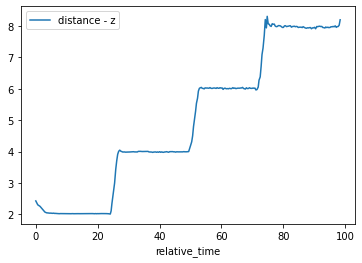

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .2)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

79

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

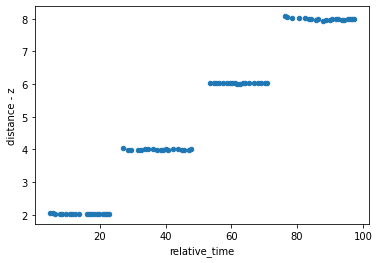

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
9,4.820632,2.043759,2
12,5.782711,2.042147,2
14,6.360645,2.035174,2
19,7.921242,2.028923,2
21,8.581357,2.029978,2
...,...,...,...
290,94.390271,7.964421,8
293,95.385107,7.979114,8
295,96.074792,7.989612,8
297,96.750010,8.006526,8


In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
9,4.820632,2.043759,2,-0.043759
12,5.782711,2.042147,2,-0.042147
80,27.121494,4.048385,4,-0.048385
85,28.689198,3.991735,4,0.008265
163,53.471043,6.047520,6,-0.047520
167,54.698241,6.032939,6,-0.032939
235,76.396760,8.074406,8,-0.074406
237,77.062905,8.062384,8,-0.062384


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,20.0,-0.030217,0.004785,-0.043759,-0.029661,-0.028855,-0.027728,-0.025688
4,19.0,-0.000281,0.013364,-0.048385,-0.001876,0.003411,0.007503,0.012262
6,19.0,-0.031213,0.009608,-0.047520,-0.037624,-0.030724,-0.026369,-0.009706
8,21.0,0.008282,0.031873,-0.074406,-0.006526,0.011146,0.030445,0.054768


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

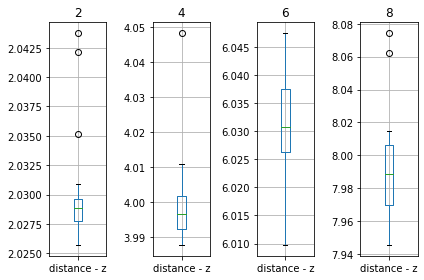

In [16]:
box_plotter(target)

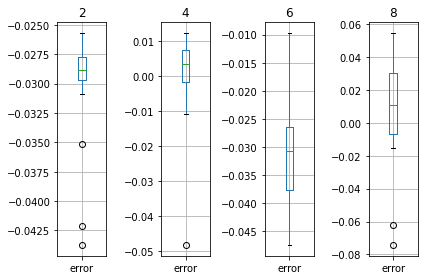

In [17]:
box_plotter('error')